<a href="https://www.kaggle.com/georgemorales/medical-cost-notebook-linear-regression?scriptVersionId=89487213" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


This is my notebook on the medical cost dataset. I am studying linear regression at the time of writing this notebook so I will only be using linear regression on this notebook and apply the things I have learned from the book "Introduction to Statistical Learning with Applications in R" by Gareth James, et.al.

In [2]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")

Because we don't have a separate file for test dataset, we ought to split the data here before doing anything.


In [3]:
# Lets separate a test dataset from the dataframe using the Dataframe.sample() function.
test_df = df.sample(frac=0.20)
# then remove the samples from the original df, the remaining observations will be used for training.
train_df = df.drop(test_df.index)

We'll use the `train_df` to make a model for predicting the medical cost data set and the `test_df` to evaluate the linear model that we made. 

Let's check for missing values.

In [4]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.485981,13.952455,18.0000,27.000000,39.50000,51.000000,64.00000
bmi,1070.0,30.790650,6.165018,15.9600,26.400000,30.50000,34.892500,53.13000
children,1070.0,1.108411,1.210889,0.0000,0.000000,1.00000,2.000000,5.00000
charges,1070.0,13274.268554,12168.442182,1121.8739,4746.521225,9333.01435,16252.210625,62592.87309


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 3 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


There are no missing values so we can proceed with EDA.

# EDA

In [7]:
# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

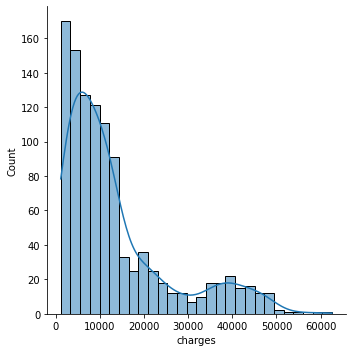

In [8]:
# Distribution of the response
sns.displot(x='charges', data = train_df, kde = True)

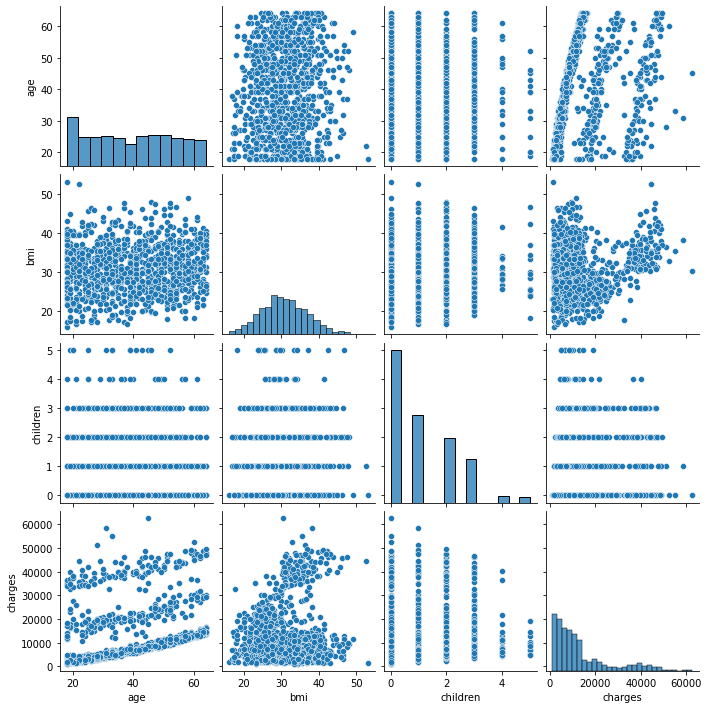

In [9]:
sns.pairplot(train_df)

There seems to be a pattern between charges and age

<AxesSubplot:xlabel='age', ylabel='charges'>

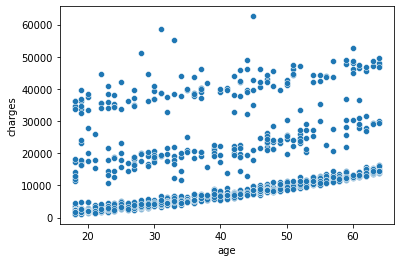

In [10]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df)

We can observe three linear patterns here. 

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 3 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   charges   1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 99.2+ KB


Let's try separating the points using the categorical variables

<AxesSubplot:xlabel='age', ylabel='charges'>

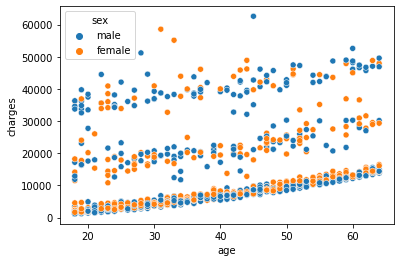

In [12]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'sex')

<AxesSubplot:xlabel='age', ylabel='charges'>

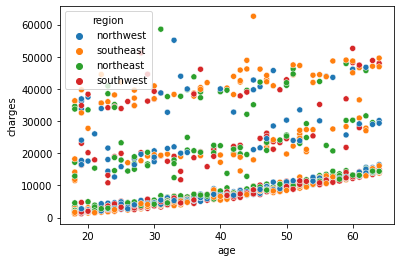

In [13]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'region')

<AxesSubplot:xlabel='age', ylabel='charges'>

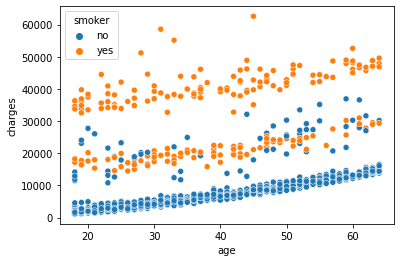

In [14]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'smoker')

Smokers and non-smokers are dividing the linear patterns almost perfectly. Non-smokers tend to have less charges, and smokers have larger charges. Then there is the line in the middle with a mix of both.

<AxesSubplot:xlabel='smoker', ylabel='charges'>

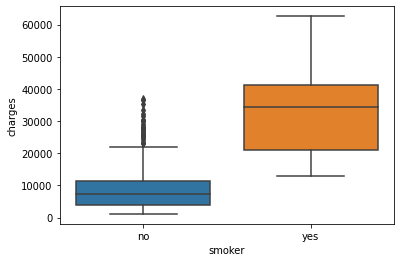

In [15]:
sns.boxplot(x = 'smoker', y = 'charges', data = train_df)

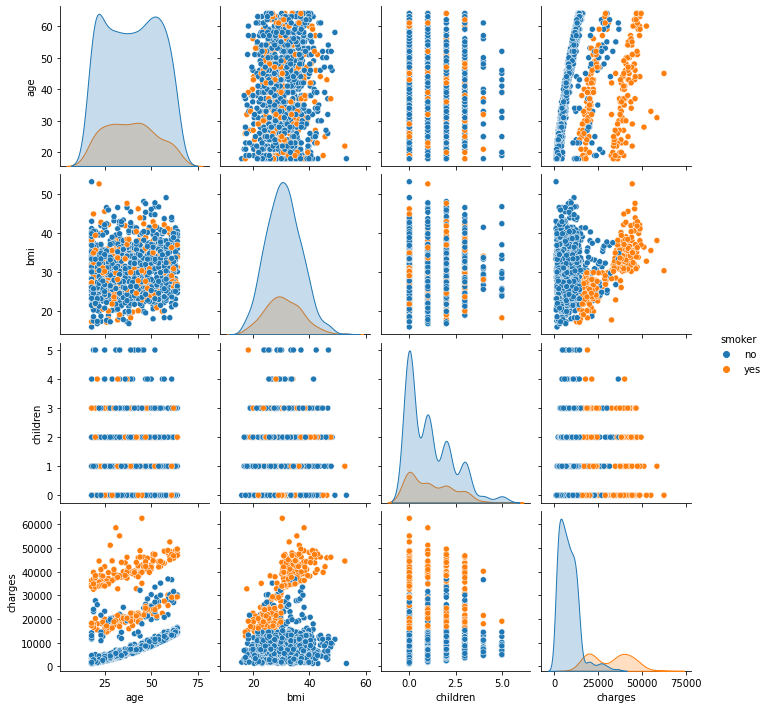

In [16]:
sns.pairplot(train_df, hue = 'smoker')

A  clear division from smokers and non-smokers can also be seen between charges and bmi.

# Preprocessing

In [17]:
train_df.head()

,age,sex,bmi,children,smoker,region,charges
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560


In [18]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
quantitative_var = train_df.drop('charges', axis=1).select_dtypes(include='number').columns
qualitative_var = train_df.select_dtypes(include='object').columns
train_df[quantitative_var]= scaler.fit_transform(train_df[quantitative_var])
train_df = pd.get_dummies(train_df, drop_first = True)

In [19]:
train_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
3,-0.465080,-1.312150,-0.915798,21984.47061,1,0,1,0,0
4,-0.536786,-0.310063,-0.915798,3866.85520,1,0,1,0,0
5,-0.608491,-0.819626,-0.915798,3756.62160,0,0,0,1,0
6,0.467091,0.429940,-0.089572,8240.58960,0,0,0,1,0
7,-0.178259,-0.495064,1.562879,7281.50560,0,0,1,0,0


# Modeling

Reading *Dannynynynyny123* and *Yosuke Shiraishi*'s discussion (link [here](https://www.kaggle.com/mirichoi0218/insurance/discussion/255722)), I am inspired to also create 3 different linear models and see the significance of each predictive variable to the response for each model. Before we do that, we should first figure out how to divide the observations so that we get the three lines.


This is what we're going to do:
1. Separate the observations to low, middle, high. Arbitrarily.
2. Then we create the linear models.
    - split the observations according to cluster
    - split the clusters to train and test
    - make a linear model for each cluster
    - evaluate the models
3. Improve the models. 
    - Feature selection (forward, backward, stepwise)
    - remove outliers
    - remove high leverage points
4. Evaluate
5. Create a classifier for the low, middle, high column
6. Classify the test set
7. Evaluate the models using the test set.

> How well will this approach be compared to just using one linear model.

## Separate the observations to low, middle, high

In [20]:
### We can see that the lowest line has a 'charges' that ranges from 0 up to about 15,000
### The middle from 15,000 up to 30,000
### The highest line from 30k onwards.
### Let's divide the observations according to this
### Since I don't know what to call this variable I'd just call it cluster.

### define a function to set each observation to a cluster according to charges
def cluster(x):
    if x < 15000:
        return 'low'
    elif x < 30000:
        return 'middle'
    else:
        return 'high'
### apply the function to the dataframe
train_df['cluster'] = train_df['charges'].map(cluster)

        

<AxesSubplot:xlabel='age', ylabel='charges'>

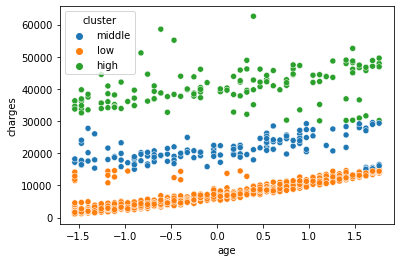

In [21]:
sns.scatterplot(x = 'age', y = 'charges', data = train_df, hue = 'cluster')

I'd say this is good enough. Now when it comes time to test the models using the test dataset, we need to first classify the observations as low middle and high before predicting the charges. We'll do that later.

## Create linear models for each cluster
- split the observations according to cluster
- split the clusters to train and test
- make a linear model for each cluster
- evaluate the models

In [22]:
### split the observations according to cluster
train_lo = train_df[train_df['cluster'] == 'low']
train_md = train_df[train_df['cluster'] == 'middle']
train_hi = train_df[train_df['cluster'] == 'high']

In [23]:
train_lo.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,cluster
4,-0.536786,-0.310063,-0.915798,3866.8552,1,0,1,0,0,low
5,-0.608491,-0.819626,-0.915798,3756.6216,0,0,0,1,0,low
6,0.467091,0.429940,-0.089572,8240.5896,0,0,0,1,0,low
7,-0.178259,-0.495064,1.562879,7281.5056,0,0,1,0,0,low
8,-0.178259,-0.155896,0.736653,6406.4107,1,0,0,0,0,low


In [24]:
### split the clusters to train and valid
from sklearn.model_selection import train_test_split
### we don't need the cluster column anymore
X_lo = train_lo.drop(['charges','cluster'], axis = 1)
y_lo = train_lo['charges']
X_md = train_md.drop(['charges','cluster'], axis = 1)
y_md = train_md['charges']
X_hi = train_hi.drop(['charges','cluster'], axis = 1)
y_hi = train_hi['charges']

In [25]:
### split the clusters to train and valid(test)
X_train_lo, X_test_lo, y_train_lo, y_test_lo = train_test_split(X_lo, y_lo, test_size = 0.20, random_state = 42)
X_train_md, X_test_md, y_train_md, y_test_md = train_test_split(X_md, y_md, test_size = 0.20, random_state = 42)
X_train_hi, X_test_hi, y_train_hi, y_test_hi = train_test_split(X_hi, y_hi, test_size = 0.20, random_state = 42)

In [26]:
### make a linear model for each cluster
from sklearn.linear_model import LinearRegression
lr_lo = LinearRegression()
lr_md = LinearRegression()
lr_hi = LinearRegression()

lr_lo.fit(X_train_lo, y_train_lo)
lr_md.fit(X_train_md, y_train_md)
lr_hi.fit(X_train_hi, y_train_hi)

LinearRegression()

In [27]:
predict_lo = lr_lo.predict(X_test_lo)
predict_md = lr_md.predict(X_test_md)
predict_hi = lr_hi.predict(X_test_hi)

In [28]:
from sklearn.metrics import mean_squared_error
print(f'RMSE for low: {0}',np.sqrt(mean_squared_error(y_test_lo, predict_lo)))
print(f'RMSE for middle: {0}',np.sqrt(mean_squared_error(y_test_md, predict_md)))
print(f'RMSE for high: {0}',np.sqrt(mean_squared_error(y_test_hi, predict_hi)))

RMSE for low: 0 1157.016554916132
RMSE for middle: 0 3783.4403343274894
RMSE for high: 0 4637.932144937911


Let's compare the performance of the three models against one single linear model.

In [29]:
### What we can do is combine the predictions of the three models and compute for the RMSE 
### then compare it to the single linear model.
predicted = np.concatenate([predict_lo, predict_md, predict_hi], axis = 0)
true_values = pd.concat([y_test_lo, y_test_md, y_test_hi], axis = 0, ignore_index = True)


In [30]:
print(f'RMSE for three models: {0}',np.sqrt(mean_squared_error(true_values, predicted)))

RMSE for three models: 0 2390.7986455125715


In [31]:
### Let's make a single linear model for all the observations
X = train_df.drop(['charges', 'cluster'], axis = 1)
X = pd.get_dummies(X, drop_first = True)
y = train_df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
lr = LinearRegression()
lr.fit(X_train, y_train)
predict_all = lr.predict(X_test)


In [32]:
print(f'RMSE for single linear model: {0}',np.sqrt(mean_squared_error(y_test, predict_all)))

RMSE for single linear model: 0 6299.756997340097


The RMSE is better when using three linear models compared to just using a single linear model. So we will go with the former but we will improve it first.

Since we've decided to use three models, we will also need a classifier to determine which linear model we should use for an observation.
1. Make a classifier
    - I'll use logistic regression, because I want to use the models I have studied from ISLR.
2. Improve the models(classifier, regressor)


In [33]:
train_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,cluster
3,-0.465080,-1.312150,-0.915798,21984.47061,1,0,1,0,0,middle
4,-0.536786,-0.310063,-0.915798,3866.85520,1,0,1,0,0,low
5,-0.608491,-0.819626,-0.915798,3756.62160,0,0,0,1,0,low
6,0.467091,0.429940,-0.089572,8240.58960,0,0,0,1,0,low
7,-0.178259,-0.495064,1.562879,7281.50560,0,0,1,0,0,low


In [34]:
X = train_df.drop(['charges', 'cluster'], axis = 1)
y = train_df['cluster']
cluster = {'low': 0, 'middle': 1, 'high': 2 }
y = y.map(cluster)


In [35]:
y.value_counts()

0    790
1    144
2    136
Name: cluster, dtype: int64

There is a class imbalance between 0 and everything else. Let's balance the classes using undersampling

In [36]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X, y)


In [37]:
y_res.value_counts()

0    136
1    136
2    136
Name: cluster, dtype: int64

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 42)

In [39]:
from sklearn.linear_model import LogisticRegression
glm = LogisticRegression(solver = 'liblinear', random_state = 42)
glm.fit(X_train, y_train)
classified = glm.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
print('confusion matrix \n', confusion_matrix(y_test, classified))
print('classification report \n', classification_report(y_test, classified))

confusion matrix 
 [[30  3  0]
 [11 13  1]
 [ 2  0 22]]
classification report 
               precision    recall  f1-score   support

           0       0.70      0.91      0.79        33
           1       0.81      0.52      0.63        25
           2       0.96      0.92      0.94        24

    accuracy                           0.79        82
   macro avg       0.82      0.78      0.79        82
weighted avg       0.81      0.79      0.79        82



In [41]:
param_grid_lr = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)
logModel_grid.fit(X_train, y_train)
print(logModel_grid.best_estimator_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='newton-cg')


In [43]:
y_pred = logModel_grid.predict(X_test)
print(y_pred)

[0 0 1 0 0 0 1 1 1 1 0 0 2 2 0 1 1 0 0 0 0 2 2 1 2 2 0 1 0 2 0 0 0 0 2 1 0
 2 0 1 2 2 0 0 0 2 0 2 1 0 2 0 0 0 2 2 0 0 1 0 0 0 0 1 0 0 2 0 0 2 1 2 0 1
 0 0 0 0 2 2 2 2]


In [44]:
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix \n")
print('classification report \n', classification_report(y_test, y_pred))

[[31  1  1]
 [10 13  2]
 [ 2  2 20]] : is the confusion matrix 

classification report 
               precision    recall  f1-score   support

           0       0.72      0.94      0.82        33
           1       0.81      0.52      0.63        25
           2       0.87      0.83      0.85        24

    accuracy                           0.78        82
   macro avg       0.80      0.76      0.77        82
weighted avg       0.79      0.78      0.77        82



In [45]:
train_df

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,cluster
3,-0.465080,-1.312150,-0.915798,21984.47061,1,0,1,0,0,middle
4,-0.536786,-0.310063,-0.915798,3866.85520,1,0,1,0,0,low
5,-0.608491,-0.819626,-0.915798,3756.62160,0,0,0,1,0,low
6,0.467091,0.429940,-0.089572,8240.58960,0,0,0,1,0,low
7,-0.178259,-0.495064,1.562879,7281.50560,0,0,1,0,0,low
...,...,...,...,...,...,...,...,...,...,...
1330,1.255851,-0.819626,0.736653,12629.16560,0,0,0,1,0,low
1331,-1.182135,0.423449,-0.915798,10795.93733,0,0,0,0,1,low
1332,0.897324,2.257229,1.562879,11411.68500,0,0,0,0,1,low
1335,-1.540663,0.983320,-0.915798,1629.83350,0,0,0,1,0,low


Improve the models:
- Linear regression
    - Feature selection
    - Remove outliers
    - Remove high leverage points
- Logistic regression
    - Feature selection


In [46]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cluster   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     71.65
Date:                Mon, 07 Mar 2022   Prob (F-statistic):           1.57e-66
Time:                        11:29:44   Log-Likelihood:                -226.24
No. Observations:                 326   AIC:                             470.5
Df Residuals:                     317   BIC:                             504.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3103      0.069      4.508      0.000       0.175       0.446
age                  0.0609      0.027      2.238      0.026       0.007       0.114
bmi                  0.2086      0.028      7.393      0.000       0.153       0.264
children             0.0502      0.029      1.733      0.084      -0.007       0.107
sex_male             0.0722      0.056      1.297      0.196      -0.037       0.182
smoker_yes           1.2501      0.056     22.254      0.000       1.140       1.361
region_northwest     0.0027      0.081      0.033      0.973      -0.157       0.162
region_southeast    -0.0746      0.076     -0.983      0.327      -0.224       0.075
region_southwest    -0.0406      0.080     -0.504      0.614      -0.199       0.118
==============================================================================
Omnibus:                       41.858   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.226
Skew:                           0.883   Prob(JB):                     6.17e-13
Kurtosis:                       4.010   Cond. No.                         6.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For a single linear model: `region`, `gender`, `children`, and `age` are not statistically significant if our alpha is 0.01. That leaves us with `smoker` and `bmi`

# Feature selection

## For the linear models

In [47]:
import statsmodels.api as sm

def forward_selection(X, y, threshold_in=0.01, verbose=True):
    include = []
    changed = True
    while changed:
        exclude = list(set(X.columns) - set(include))
        pvalues = pd.Series(index=list(X.columns), dtype=float)
        for column in exclude:
            model = sm.OLS(y, sm.add_constant(X[include + [column]])).fit()
            pvalues[column] = model.pvalues[column]
        best_pvalue = pvalues.min()
        if best_pvalue < threshold_in:
            include.append(pvalues.index[pvalues.argmin()])
            if verbose:
                print("Include: {0}\t p-value: {1}".format(pvalues.index[pvalues.argmin()], best_pvalue))
            continue
        changed = False
        
        return include

### low

In [48]:
train_lo = train_df[train_df['cluster'] == 'low']
X_lo = train_lo.drop(['charges', 'cluster'], axis=1)
X_lo = pd.get_dummies(X_lo, drop_first = True)
y_lo = train_lo['charges']
X_lo_train, X_lo_test, y_lo_train, y_lo_test = train_test_split(X_lo, y_lo, test_size = 0.20, random_state = 72)

In [49]:
features_lo = forward_selection(X_lo_train, y_lo_train)
X_lo_train = X_lo_train[features_lo]

Include: age	 p-value: 6.07364585202379e-244
Include: children	 p-value: 1.4103187005232063e-15
Include: smoker_yes	 p-value: 5.817083567795735e-12
Include: sex_male	 p-value: 2.2434120559647222e-05


### middle

In [50]:
train_md = train_df[train_df['cluster'] == 'middle']
X_md = train_md.drop(['charges', 'cluster'], axis=1)
X_md = pd.get_dummies(X_md, drop_first = True)
y_md = train_md['charges']
X_md_train, X_md_test, y_md_train, y_md_test = train_test_split(X_md, y_md, test_size = 0.20, random_state = 72)

In [51]:
features_md = forward_selection(X_md_train, y_md_train)
X_md_train = X_md_train[features_md]

Include: age	 p-value: 1.4367775599893141e-06


### high

In [52]:
train_md = train_df[train_df['cluster'] == 'high']
X_hi = train_hi.drop(['charges', 'cluster'], axis=1)
X_hi = pd.get_dummies(X_hi, drop_first = True)
y_hi = train_hi['charges']
X_hi_train, X_hi_test, y_hi_train, y_hi_test = train_test_split(X_hi, y_hi, test_size = 0.20, random_state = 72)

In [53]:
features_hi = forward_selection(X_hi_train, y_hi_train)
X_hi_train = X_hi_train[features_hi]

Include: age	 p-value: 4.528603781535107e-09
Include: bmi	 p-value: 8.468219586087836e-08
Include: smoker_yes	 p-value: 1.0211151042502958e-07


Let's make a linear regression model according to the 'best' features for each cluster.

In [54]:
lr_lo.fit(X_lo_train, y_lo_train)
lr_md.fit(X_md_train, y_md_train)
lr_hi.fit(X_hi_train, y_hi_train)
y_lo_pred = lr_lo.predict(X_lo_test[features_lo])
y_md_pred = lr_md.predict(X_md_test[features_md])
y_hi_pred = lr_hi.predict(X_hi_test[features_hi])

In [55]:
print(f'RMSE for low: {0}',np.sqrt(mean_squared_error(y_lo_test, y_lo_pred)))
print(f'RMSE for middle: {0}',np.sqrt(mean_squared_error(y_md_test, y_md_pred)))
print(f'RMSE for high: {0}',np.sqrt(mean_squared_error(y_hi_test, y_hi_pred)))

RMSE for low: 0 947.9884327272673
RMSE for middle: 0 3288.344416909626
RMSE for high: 0 4471.038574986471


In [56]:
y_all_pred = np.concatenate([y_lo_pred, y_md_pred, y_hi_pred], axis = 0)
y_all_test = pd.concat([y_lo_test, y_md_test, y_hi_test], axis = 0, ignore_index = True)
print(f'RMSE for combined: {0}',np.sqrt(mean_squared_error(y_all_test, y_all_pred)))

RMSE for combined: 0 2173.09128678561


## For the logistic regression

In [57]:
print(logModel_grid.best_estimator_)

LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='newton-cg')


In [58]:

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.20, random_state = 42)

In [59]:
print(np.sqrt(X_train.shape[0]))

18.05547008526779


In [60]:
## sklearn has a module called SequentialFeatureSelector that can perform forward selection. 
## Let's use that instead of the function we made, just to try it.
from sklearn.feature_selection import SequentialFeatureSelector

## This method uses f1_macro as the scoring parameter for forward selection
## You can define your own scoring parameter 
## or use the predefined ones here https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg = LogisticRegression(class_weight = 'balanced', max_iter=20, solver='newton-cg', random_state = 42)
SFS_forward = SequentialFeatureSelector(logreg, n_features_to_select = 5 , direction = 'forward', scoring='f1_macro', cv = 5)
SFS_forward.fit(X_train, y_train)
selected_SFS_forward = X_train.columns[SFS_forward.support_]
removed_SFS_forward = X_train.columns[~SFS_forward.support_]

In [61]:
selected_SFS_forward

Index(['bmi', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast'],
      dtype='object')

In [62]:
logreg.fit(X_train[selected_SFS_forward], y_train)

LogisticRegression(class_weight='balanced', max_iter=20, random_state=42,
                   solver='newton-cg')

In [63]:
y_pred = logreg.predict(X_test[selected_SFS_forward])

In [64]:
print('confusion matrix \n', confusion_matrix(y_test, y_pred))
print('classification report \n', classification_report(y_test, y_pred))

confusion matrix 
 [[30  2  1]
 [11 13  1]
 [ 2  1 21]]
classification report 
               precision    recall  f1-score   support

           0       0.70      0.91      0.79        33
           1       0.81      0.52      0.63        25
           2       0.91      0.88      0.89        24

    accuracy                           0.78        82
   macro avg       0.81      0.77      0.77        82
weighted avg       0.80      0.78      0.77        82



In [65]:
## sklearn has a module called SequentialFeatureSelector that can performs forward selection. 
## Let's use that instead of the function we made, just to try it.
from sklearn.feature_selection import SequentialFeatureSelector

## This method uses f1_micro as the scoring parameter for forward selection
## You can define your own scoring parameter 
## or use the predefined ones here https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg = LogisticRegression(class_weight = 'balanced', max_iter=200,solver='newton-cg', random_state = 42)
SFS_forward = SequentialFeatureSelector(logreg, n_features_to_select = 5 , direction = 'forward', scoring='f1_micro', cv = 5)
SFS_forward.fit(X_train, y_train)
selected_SFS_forward = X_train.columns[SFS_forward.support_]
removed_SFS_forward = X_train.columns[~SFS_forward.support_]


In [66]:
selected_SFS_forward

Index(['bmi', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast'],
      dtype='object')

selected variables for `f1_micro` and `f1_macro` are the same.

TODO:
- use cross validation 
- evaluate the performanceof your models on the test dataset
- rename variables 
- explain what you did
- compare your linear models to complex models



# Continue EDA tomorrow, also check other people's codes to learn more.

Use this notebook for inspiration. https://www.kaggle.com/ahmetsulukaya/regression-model. dont forget to reference it

> Note to self, need to make dummy variables first before making a model.

Do this after EDA maybe:
https://www.datasklr.com/ols-least-squares-regression/variable-selection

TODO:
- Needs improvement in the EDA. I should include others as well. I mean, I should not stop at smoker column. 
> Even if you've found something, dont stop there. Just keep it in mind and continue investigating. When all is done then you can test what you've found.


References:
- Resampling imbalanced datasets: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
- Optimizing threshold for logistic regression: https://towardsdatascience.com/calculating-and-setting-thresholds-to-optimise-logistic-regression-performance-c77e6d112d7e
- Optimizing threshold for multi-class: https://datascience.stackexchange.com/questions/77264/finding-optimal-threshold-in-multi-class-classification-task
- Optimize Logistic regression: https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492
- Maurício Collaça's comment: https://stackoverflow.com/questions/57085897/python-logistic-regression-max-iter-parameter-is-reducing-the-accuracy
- Regression model: https://www.kaggle.com/ahmetsulukaya/regression-model
- Feature selection: https://www.datasklr.com/ols-least-squares-regression/variable-selectionhttps://www.datasklr.com/ols-least-squares-regression/variable-selection
- Feature Elimination Examples for Logistic Regression: https://darigak.medium.com/feature-elimination-examples-for-logistic-regression-7293462e197b
- https://stackoverflow.com/questions/59538006/scaling-data-frame-with-numeric-and-categorical